In [1]:
# Importing Necessary Packages and Libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchvision.datasets as datasets
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from torchvision.utils import make_grid
import torch.nn.functional as F

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We are training for 150 epochs
num_epochs = 150

# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# For training data
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])

# For test data
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

# Loading the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=train_tfms,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=test_tfms)

# Splitting test dataset into training and validation data
VALID_RATIO = 0.9

n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = data.random_split(train_dataset, 
                                           [n_train_examples, n_valid_examples])

100%|██████████| 170498071/170498071 [00:12<00:00, 13119983.40it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [3]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=400, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=400, 
                                          shuffle=False)

valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                          batch_size=400, 
                                          shuffle=False)

In [4]:
# Function to plot images in a grid from the dataset
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [5]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_dataset[i] for i in range(N_IMAGES)]])

classes = test_dataset.classes

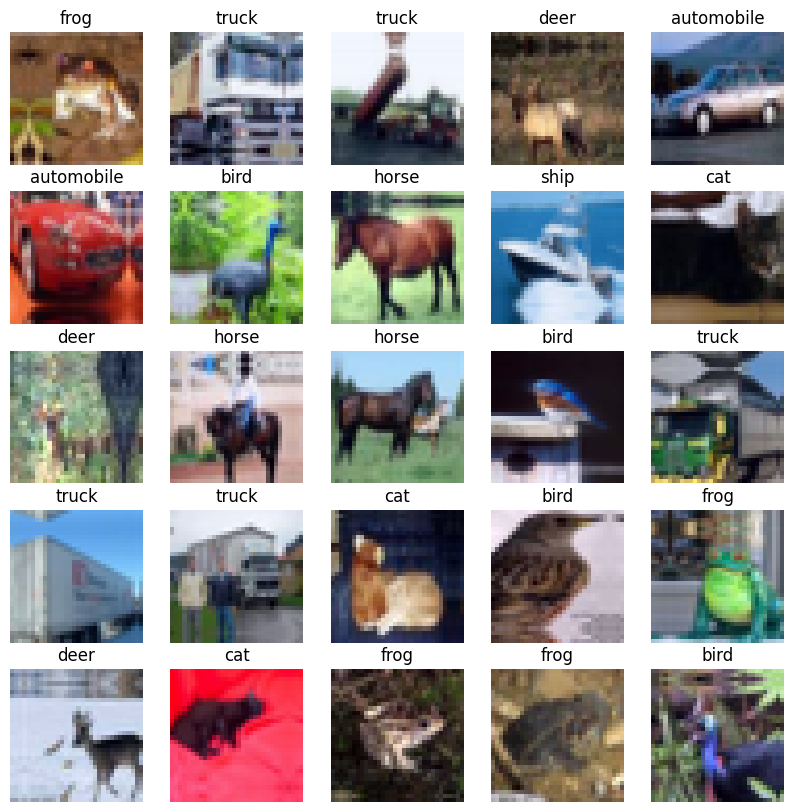

In [6]:
plot_images(images, labels, classes, normalize = True)

In [7]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
    

# Defining the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [8]:
# Define the Residual Network
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, dropout_rate=0.2):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv = conv3x3(3, 32)
        self.bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1], 2)
        self.layer3 = self.make_layer(block, 96, layers[2], 2)
        self.layer4 = self.make_layer(block, 128, layers[3], 2)
        self.layer5 = self.make_layer(block, 185, layers[4], 2)
        self.avg_pool = nn.AvgPool2d(2)
        self.fc = nn.Linear(185, num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)

    # Stacks residual blocks to generate the layers mentioned above
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        print(blocks)
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [9]:
# Creating model with 4 residual blocks in each layer
model = ResNet(ResidualBlock, [4, 4, 4, 4, 4]).to(device)

4
4
4
4
4


In [10]:
# Summarizing model, calculating number of trainable parameters
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,216
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
    ResidualBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01, weight_decay=1e-4)

# Using One Cycle LR Scheduler
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.01, total_steps=None, epochs=num_epochs, steps_per_epoch=len(train_loader))

# For updating learning rate
def get_lr(optimizer):    
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [12]:
# Train the model
total_step = len(train_loader)
train_loss = []
valid_acc = []
grad_clip = 0.1
reslrs = []
for epoch in range(num_epochs):
  epoch_loss = 0
  lrs = []
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward and optimize
    
    loss.backward()

    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    optimizer.step()
    optimizer.zero_grad()
    epoch_loss += loss.item()
    lrs.append(get_lr(optimizer))
    sched.step()  
  train_loss.append(epoch_loss/len(train_loader))
  print ("Epoch [{}/{}], Loss: {:.4f}"
                .format(epoch+1, num_epochs, epoch_loss/len(train_loader)))
  reslrs.append(lrs)
  with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            valid_outputs = model(images)
            _, predicted = torch.max(valid_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, valid_outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
        valid_acc.append(correct / total)

Epoch [1/150], Loss: 1.7466
Accuracy of the network on the 5000 validation images: 43.18 %
Epoch [2/150], Loss: 1.3439
Accuracy of the network on the 5000 validation images: 55.68 %
Epoch [3/150], Loss: 1.1065
Accuracy of the network on the 5000 validation images: 63.74 %
Epoch [4/150], Loss: 0.9361
Accuracy of the network on the 5000 validation images: 67.86 %
Epoch [5/150], Loss: 0.8184
Accuracy of the network on the 5000 validation images: 72.98 %
Epoch [6/150], Loss: 0.7349
Accuracy of the network on the 5000 validation images: 74.58 %
Epoch [7/150], Loss: 0.6671
Accuracy of the network on the 5000 validation images: 75.34 %
Epoch [8/150], Loss: 0.6191
Accuracy of the network on the 5000 validation images: 76.92 %
Epoch [9/150], Loss: 0.5760
Accuracy of the network on the 5000 validation images: 78.72 %
Epoch [10/150], Loss: 0.5409
Accuracy of the network on the 5000 validation images: 80.0 %
Epoch [11/150], Loss: 0.5162
Accuracy of the network on the 5000 validation images: 80.9 %

In [13]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 93.08 %


The model has an accuracy of **93.08%** on the test data.

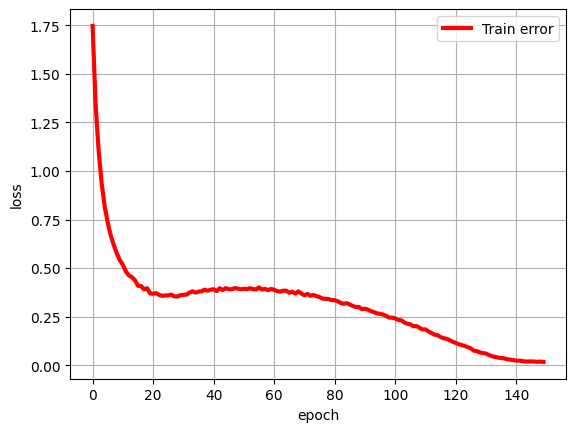

In [24]:
import matplotlib.pyplot as plt

# Plotting graph for test loss
plt.plot(range(num_epochs),train_loss,'-r',linewidth=3,label='Train error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()


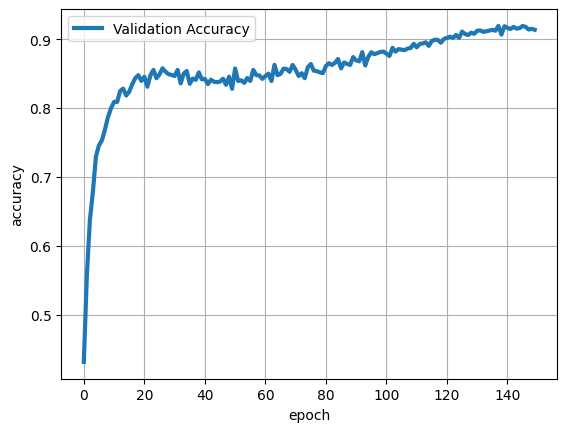

In [25]:
# Plotting graph for validation accuracy
plt.plot(range(num_epochs),valid_acc,'-',linewidth=3,label='Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()
plt.show()


[0.0004038480814533141, 0.0004271201261173496, 0.00047365430645900574, 0.0005432238234711089, 0.0006354896081666902, 0.0007500019741386527, 0.0008862028092483312, 0.0010434282957610577, 0.0012209121456712919, 0.0014177893354489434, 0.0016331003220044214, 0.0018657957193245675, 0.002114741412986426, 0.0023787240876216287, 0.0026564571403916116, 0.002946586951652378, 0.003247699482246858, 0.00355832716527079, 0.003876956058722981, 0.004202033224179222, 0.004531974295527566, 0.00486517120087639, 0.0052, 0.005534828799123606, 0.00586802570447243, 0.006197966775820777, 0.006523043941277016, 0.006841672834729208, 0.007152300517753143, 0.007453413048347623, 0.0077435428596083905, 0.008021275912378372, 0.008285258587013573, 0.008534204280675431, 0.008766899677995574, 0.00898221066455106, 0.009179087854328706, 0.00935657170423894, 0.009513797190751667, 0.009649998025861348, 0.009764510391833308, 0.009856776176528886, 0.009926345693541, 0.009972879873882646, 0.009996151918546692, 0.0099992441034

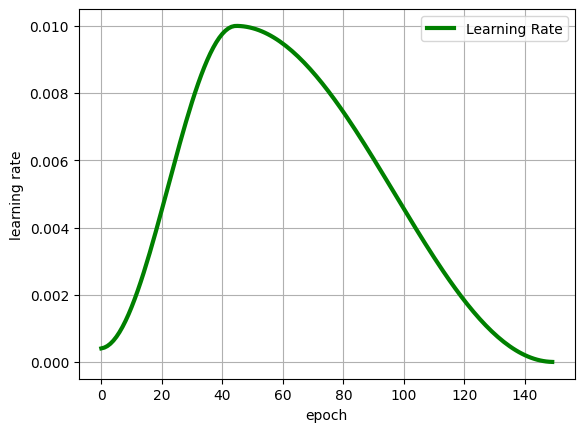

In [33]:
avg_lrs = []
for l in reslrs:
  sum = 0
  for x in l:
    sum += x
  avg_lrs.append(sum/len(l))
print(avg_lrs)

# Plotting graph for learning rate
plt.plot(range(num_epochs),avg_lrs,'-g',linewidth=3,label='Learning Rate')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')

In [15]:
# Predictions to build Confusion Matrix
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []
    with torch.no_grad():
      for x,y in iterator:
        #After evaluating the model, we run it on the test_data and
        #find the predicted and true labels to plot them against one another.
        #Here we don't need to take the gradient, hence, the function
        x=x.to(device)
        y=y.to(device)

        y_pred = model(x)

        labels.append(y.cpu())
        probs.append(y_pred.cpu())

   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [16]:
labels, probs = get_predictions(model, test_loader, device)

In [17]:
pred_labels = torch.argmax(probs, 1)

In [18]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

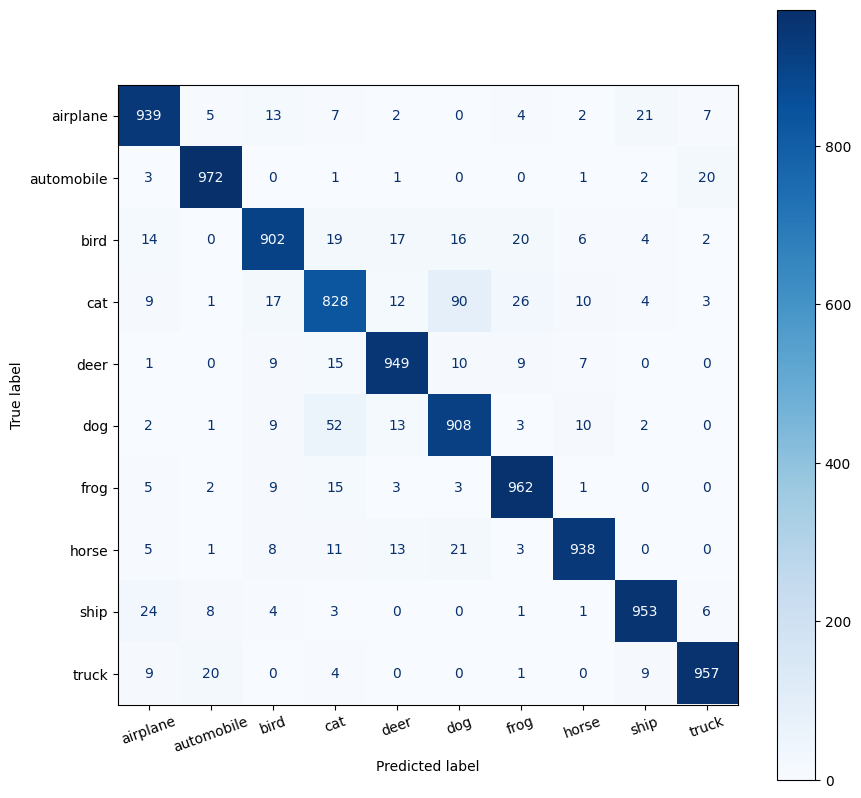

In [19]:
plot_confusion_matrix(labels, pred_labels, classes) 